<a href="https://colab.research.google.com/github/grzabrodskiy/ImageRec/blob/main/src/ImageRec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparing to use **Google Colab**

Based on the course labs



# Preparing Data Storage

1. Setting up the device

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


2. Mount Gooogle Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


3. Setting up the directories

In [ ]:
import os

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'School')


4. Unzipoing the dataset

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')
# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!unzip -q -o CW_Dataset.zip -d CW_Dataset

!ls CW_Dataset

labels	README.txt  test  train  val


# Setting up datasets

# 1: Transfer Learning

In this first part, we will learn how to train a convolutional neural network for
image classification using **transfer learning**. We have briefly encountered this concept in a previous lecture, but you can read more about it on these [note pages](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:
-  **Finetuning the CNN**: instead of random initialization, we
   initialize the network with a pretrained network, like the one that is trained on ImageNet. Since we will very likely have a different number of categories compared to the 1000 of ImageNet, we will usually need to replace the final fully-connected layer with a new one (with random weights) having the correct number of neurons. Then the rest of the training looks as usual.
-  **CNN as fixed feature extractor**: here, we will freeze the weights for all of the network except that of the final fully-connected layer, which will be replaced with a new one (with random weights and the correct number of neurons) as in the previous case. Only this layer is trained. The coding for this second approach will constitute a Task.

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by: Giacomo Tarroni
# Modified by: Greg Zabrodskiy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import shutil
from torchvision.utils import make_grid
import random


%matplotlib inline

## Loading the Data




In [ ]:
#data_dir = 'CW_Dataset'
#data_means = [0.485, 0.456, 0.406]
#data_stds = [0.229, 0.224, 0.225]


The `data_means` and `data_stds` are lists with the means and standard deviations of the pixel intensities of the three colour channels in the dataset, respectively. They will be useful to normalize the images to the [-1, 1] range that is best used with training CNNs.

Data transformation is going to be different between training and validation phases:

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
data_transforms = {

  
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Grayscale(num_output_channels=3),

        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5, inplace=True)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5, inplace=True)
    ]),
}

Set up label names

In [ ]:
class_names = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']

Create directory structure for pytorch standard loader

In [ ]:
files = {}
for t in ['test', 'train', 'val']:
  for n in range (0, 7):
    dirpath = f'CW_Dataset/{t}/sorted/' + class_names[n]
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
      shutil.rmtree(dirpath)
    os.makedirs(dirpath, exist_ok=True)


In [ ]:

val_data_size = 0.2 # use this percent value of train data for validation

for t in ['test', 'train']:
  files[t] = np.genfromtxt(f'CW_Dataset/labels/list_label_{t}.txt',dtype='str')

  for fl in files[t]:
    if fl[0].endswith('.jpg'):
      if (t == 'train') and (random.uniform(0, 1) < val_data_size):
        shutil.copy2(f'CW_Dataset/{t}/' + fl[0][:-4] + '_aligned.jpg', f'CW_Dataset/val/sorted/' + class_names[int(fl[1])-1] + '/' + fl[0][:-4] +  '_aligned.jpg')
      else:
        shutil.copy2(f'CW_Dataset/{t}/' + fl[0][:-4] + '_aligned.jpg', f'CW_Dataset/{t}/sorted/' + class_names[int(fl[1])-1] + '/' + fl[0][:-4] +  '_aligned.jpg')


Set up datasets and dataloaders

In [ ]:
image_dataset = {}
dataloader = {}
for t in ['test', 'train', 'val']:

  image_dataset[t] = datasets.ImageFolder(f'/content/CW_Dataset/{t}/sorted', data_transforms[t])

  dataloader[t] = torch.utils.data.DataLoader(image_dataset[t], batch_size=4,
                                             shuffle=True, num_workers=2)
            

Note that here both `image_datasets` and `dataloaders` have been created as dictionaries, with two elements representing the training and validation datasets, respectively.

We can also define the following variables, which will be of use for the rest of the code:

In [ ]:
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'test', 'val']}
print(dataset_sizes)
class_names = image_dataset['train'].classes
print(class_names)

{'train': 9818, 'test': 3068, 'val': 2453}
['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']


## Visualizing some images


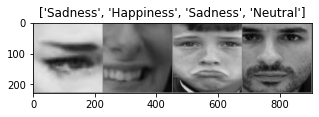

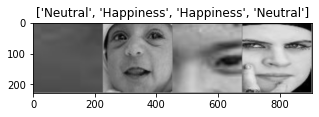

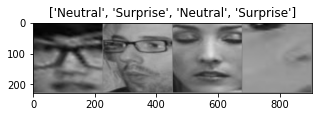

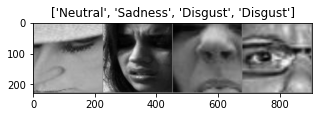

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(0.5) * inp + np.asarray(0.5)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    plt.title(title)


# Get a batch of training data
for i in range (0, 4):
  inputs, classes = next(iter(dataloader['train']))

  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  plt.figure(figsize=(5, 10))
  imshow(out, title=[class_names[x] for x in classes])
  plt.show()

## Training the model

Now, let's write a general function to train a model. The function will:

- Run for a given number of epochs
- For each epoch, there will be a training phase (where the model will be updated from the previous epoch) and a validation phase (where it will be applied to the validation set for prediction)
- Save the best model (based on the performance on the validation set)

Importantly, we will also **schedule the learning rate** (LR) (i.e. change it during training). In the function, the parameter ``scheduler`` is an LR scheduler object from [``torch.optim.lr_scheduler``](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} out of {num_epochs}")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Let's also define a generic function to use the model to predict the classes of a few images (from the validation set) and to visualize the results:

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
              images_so_far += 1
              ax = plt.subplot(1, num_images, images_so_far)
              ax.axis('off')
              ax.set_title(f"{class_names[preds[j]]}")
              print(f"Predicted for image {images_so_far}: {class_names[preds[j]]}")
              imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

              if images_so_far == num_images:
                  model.train(mode=was_training)
                  return
        model.train(mode=was_training)

## Finetuning the CNN

Finetuning a CNN consists in taking a model (i.e. **architecture and weights**) pre-trained on a given dataset (very often ImageNet) and using it as a starting point for training on a different dataset. The steps involved in finetuning are the following:

1. Load a pre-trained model
2. Reset the final layer (technically needed only if the number of classes is different between the two datasets, but generally always a good idea)
3. Perform training on the new dataset

In this example, we will first download the *ResNet18* model from the model zoo of `torchvision` (more information on how this works can be found [here](https://pytorch.org/vision/stable/models.html)). Then, we will reset the last fully-connected layer and perform training on our own dataset.

Download the pre-trained model:

In [ ]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Create a new fully-connected layer and use it to replace the original one of *Resnet18*. It will need to have the same input dimensions as the original one, but have an output size equal to the number of classes in our dataset:

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

Then we can move the model to the GPU and set the remaining training parameters and criterion (i.e. the loss function):

In [ ]:
print(device)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

cuda:0


## Train and evaluate

Now we can actually train our model. It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 1 out of 10
train loss: 1.6469 acc: 0.4195
val loss: 1.1814 acc: 0.5976

Epoch 2 out of 10
train loss: 1.3721 acc: 0.5174
val loss: 0.9929 acc: 0.6596

Epoch 3 out of 10
train loss: 1.2525 acc: 0.5562
val loss: 1.0259 acc: 0.6364

Epoch 4 out of 10
train loss: 1.1488 acc: 0.5998
val loss: 0.7732 acc: 0.7391

Epoch 5 out of 10
train loss: 1.0595 acc: 0.6237
val loss: 0.8362 acc: 0.7077

Epoch 6 out of 10
train loss: 1.0315 acc: 0.6340
val loss: 0.6787 acc: 0.7668

Epoch 7 out of 10
train loss: 0.9848 acc: 0.6558
val loss: 0.6740 acc: 0.7717

Epoch 8 out of 10
train loss: 0.8715 acc: 0.6916
val loss: 0.5773 acc: 0.8011

Epoch 9 out of 10
train loss: 0.8242 acc: 0.7083
val loss: 0.5672 acc: 0.8076

Epoch 10 out of 10
train loss: 0.8145 acc: 0.7160
val loss: 0.5454 acc: 0.8096

Training complete in 11m 15s
Best val acc: 0.809621


Let's test our final result on some images:

Predicted for image 1: Happiness
Predicted for image 2: Neutral
Predicted for image 3: Happiness
Predicted for image 4: Happiness
Predicted for image 5: Happiness
Predicted for image 6: Happiness
Predicted for image 7: Happiness
Predicted for image 8: Happiness
Predicted for image 9: Surprise
Predicted for image 10: Sadness


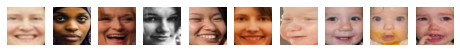

In [ ]:
plt.figure(figsize=(8, 6))
visualize_model(model_ft, 10)
plt.show()

In [ ]:
torch.save(model_ft.state_dict(), 'CNN.pth')

You should now see the model file in the *Files* folder in the toolbar on the left side. 

PyTorch offers other ways to achieve model persistence and also provides an easy way to **load directly on CPU models that were trained on GPU** (allowing testing on machines without acceleration). To learn more about these topics, make sure to visit this [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).